<a href="https://colab.research.google.com/github/ChoiDae1/Transfomer-PyTorch/blob/main/Implementing_Transfomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Transfomer 구현**

"Attention is All You Need"(NIPS 2017)에서 제안했던 Transfomer를 구현


### **데이터 전처리 함수 정의 및 필요한 라이브러리 다운**

In [1]:
!pip install torchtext==0.6.0   #BLUE Score 사용을 위한 라이브러리

     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 45.1 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0


In [2]:
%%capture
!python -m spacy download en
!python -m spacy download de   # 텍스트 토큰화, 태깅을 위한 spacy 라이브러리 

In [3]:
import spacy

spacy_en = spacy.load('en') # 영어 토큰화(tokenization)
spacy_de = spacy.load('de') # 독일어 토큰화(tokenization)

In [4]:
# 토큰화 기능 테스트
tokenized = spacy_en.tokenizer("I am a student")

for i, token in enumerate(tokenized):
    print(f'인덱스{i}: {token.text}')


인덱스0: I
인덱스1: am
인덱스2: a
인덱스3: student


In [5]:
# 영어, 독일어 토큰화 함수 정의

def tokenize_de(text): # 독일어
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text): # 영어
    return [token.text for token in spacy_en.tokenizer(text)]

In [6]:
# Field 라이브러리를 사용해 전처리 class 정의 
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True) # batch_first=True 무조건해야 함
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

### **Multi30k 데이터셋 불러오기 및 데이터셋 분할**

In [7]:
# 대표적인 영어-독일 번역 데이터셋 Multi30k 불러오기
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 721kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 282kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 264kB/s]


In [8]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [9]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


In [10]:
# Field 객체의 build_vocab 메서드를 이용해 영어와 독어의 단어 사전을 생성 -> 최소 2번 이상 등장한 단어만 선택
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)
print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7855
len(TRG): 5893


In [11]:
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


In [12]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
print(SRC_PAD_IDX)

1


In [13]:
# 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋음 -> 이를위해 BucketIterator 사용
BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능, 참고로 앞서 build_vocab을 사용해 만든 영어와 독일사전을 기준으로 부여된 인덱스가 자동으로 활용됨.
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE)

In [14]:
import torch

for i, batch in enumerate(train_iterator): 
    src = batch.src
    trg = batch.trg
    print(f'첫 번째 배치의 shape {src.shape}')
    print(f'첫 번째 배치의 shape {trg.shape}')
    trg_pad_mask = (trg != 1).unsqueeze(1).unsqueeze(2)
    print(trg.shape)
    #print(trg_pad_mask.shape)
    #trg_sub_mask = torch.tril(torch.ones((trg.shape[1], trg.shape[1]))).bool()
    #print(trg_sub_mask.shape)
    #print(trg_sub_mask)
    #mask = trg_pad_mask & trg_sub_mask
    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}")

    # 첫 번째 배치만 확인
    break
    

첫 번째 배치의 shape torch.Size([128, 24])
첫 번째 배치의 shape torch.Size([128, 26])
torch.Size([128, 26])
인덱스 0: 2
인덱스 1: 43
인덱스 2: 41
인덱스 3: 53
인덱스 4: 7
인덱스 5: 6
인덱스 6: 353
인덱스 7: 10
인덱스 8: 5
인덱스 9: 13
인덱스 10: 710
인덱스 11: 7
인덱스 12: 17
인덱스 13: 115
인덱스 14: 4
인덱스 15: 3
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1


### **Implementing Transfomer Architecture** 
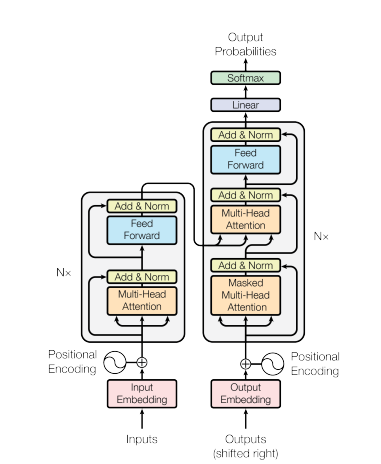

In [80]:
# Multi Head Attention -> input size: (batch_size, seq_len, embedding_dim)이 여야 함. seq_len = query_len 또는 key_len 또는 value_len
import torch.nn as nn

class MHALayer(nn.Module):
    def __init__(self, embedding_dim, model_dim, num_heads): # model_dim = num_heads * head_dim
        super(MHALayer, self).__init__()
        self.q = nn.Linear(embedding_dim, model_dim)
        self.k = nn.Linear(embedding_dim, model_dim)
        self.v = nn.Linear(embedding_dim, model_dim)
        
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        self.scale_factor = torch.sqrt(torch.FloatTensor([self.head_dim]))
        self.o = nn.Linear(model_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.q(query) # (batch_size, query_len, model_dim)
        K = self.k(key)  # (batch_size, key_len, model_dim)
        V=  self.v(value) # (batch_size, value_len, model_dim)
        
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3) # (batch_size, num_heads, query_len, head_dim)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3) # (batch_size, num_heads, key_len, head_dim)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3) # (batch_size, num_heads, value_len, head_dim)

        # Attention Energy 
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale_factor # (batch_size, num_heads, query_len, key_len)

        # mask use case
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기 -> 이 부분은 softmax를 거치면서 무시되는 값들임
            energy = energy.masked_fill(mask==0, -1e10)
        
        attention = torch.softmax(energy, dim=-1) # (batch_size, num_heads, query_len, key_len)
        
        # Scaled Dot-Product Attention
        x = torch.matmul(attention, V) # (batch_size, num_heads, query_len, head_dim), 이 연산에서는 key_len과 value_len이 같아야 함.

        x = x.permute(0, 2, 1, 3).contiguous() # (batch_size, query_len, num_heads, head_dim)
        x = x.view(batch_size, -1, self.model_dim) # (batch_size, query_len, model_dim)

        x = self.o(x) # (batch_size, query_len, embedding_dim)
        
        return x, attention

# Feedforward Layer -> input size: (batch_size, seq_len, embedding_dim)
class FeedforwardLayer(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout_rate):
        super(FeedforwardLayer, self).__init__()

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, input):
        x = self.dropout(self.fc1(input))
        x = self.fc2(x)

        return x

In [81]:
# EncoderLayer
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, model_dim, num_heads, hidden_dim, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.mha = MHALayer(embedding_dim, model_dim, num_heads)
        self.feedforward = FeedforwardLayer(embedding_dim, hidden_dim, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, input, input_mask=None): #필요한 경우 mask 사용, input size: (batch_size, seq_len, embedding_size)
        out1, _ = self.mha(input, input, input, input_mask)
        out2 = self.layer_norm(self.dropout(out1) + input)
        out3 = self.feedforward(out2)
        out4 = self.layer_norm(self.dropout(out3) + out2)

        return out4

In [82]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_layers, model_dim, num_heads, hidden_dim, dropout_rate, max_length=100):
        super(Encoder, self).__init__()

        self.tok_embedding = nn.Embedding(input_dim, embedding_dim)
        self.pos_embedding = nn.Embedding(max_length, embedding_dim)
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, model_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.scale = torch.sqrt(torch.FloatTensor([embedding_dim]))
        
    def forward(self, input, input_mask=None):
        # input_mask: [batch_size, seq_len]
        batch_size = input.shape[0]
        seq_len = input.shape[1]
        
        # Positional Encoding
        pos = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1) # (batch_size, seq_len)
        x = self.dropout((self.tok_embedding(input) * self.scale) + self.pos_embedding(pos)) # (batch_size, seq_len, embedding_dim)

        for layer in self.layers:
            x = layer(x, input_mask)
        
        return x


In [83]:
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, model_dim, num_heads, hidden_dim, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.self_attention = MHALayer(embedding_dim, model_dim, num_heads)
        self.encoder_attention = MHALayer(embedding_dim, model_dim, num_heads)
        self.feedforward = FeedforwardLayer(embedding_dim, hidden_dim, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, input, enc_output, input_mask, enc_mask):
        # input: [batch_size, seq_len(decoder), embedding_dim]
        # enc_src: [batch_size, seq_len(encoder's output), embedding_dim]
        # input_mask: [batch_size, seq_len(decoder)]
        # enc_mask: [batch_size, seq_len(encoder's output)]

        out1, _ = self.self_attention(input, input, input, input_mask)
        out2 = self.layer_norm(input + self.dropout(out1))
        out3, attention  = self.encoder_attention(out2, enc_output, enc_output, enc_mask)
        out4 = self.layer_norm(out2 + self.dropout(out3))
        out5 = self.feedforward(out4)
        out6 = self.layer_norm(out4 + self.dropout(out5))

        # out6: (batch_size, seq_len(decoder), embedding_dim)
        # attention: (batch_size, num_heads, seq_len(decoder), seq_len(encoder's output))
        return out6, attention


In [96]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, num_layers, model_dim, num_heads, hidden_dim, dropout_rate, max_length=100):
        super(Decoder, self).__init__()

        self.tok_embedding = nn.Embedding(output_dim, embedding_dim)
        self.pos_embedding = nn.Embedding(max_length, embedding_dim)

        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, model_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)])
        self.fc_out = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.scale = torch.sqrt(torch.FloatTensor([embedding_dim]))
    
    def forward(self, input, enc_output, input_mask, enc_mask):
        batch_size = input.shape[0]
        seq_len = input.shape[1]

        pos = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1)
        x = self.dropout((self.tok_embedding(input) * self.scale) + self.pos_embedding(pos)) # (batch_size, seq_len, embedding_dim)

        for layer in self.layers:
            x, attention = layer(x, enc_output, input_mask, enc_mask)
        
        x = self.fc_out(x)
        
        return x, attention 


In [97]:
# Transfomer
class Transfomer(nn.Module):
    def __init__(self, encoder, decoder, enc_pad_idx, dec_pad_idx):
        super(Transfomer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.enc_pad_idx = enc_pad_idx
        self.dec_pad_idx = dec_pad_idx
    
    def make_enc_mask(self, enc_input):
        enc_mask = (enc_input != self.enc_pad_idx).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_len(encoder))
        
        return enc_mask
    
    def make_dec_mask(self, dec_input):
        dec_pad_mask = (dec_input != self.dec_pad_idx).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_len(decoder))

        dec_len = dec_input.shape[1]
        dec_sub_mask = torch.tril(torch.ones(dec_len, dec_len)).bool() # (seq_len(decoder), seq_len(decoder))

        dec_mask = dec_pad_mask & dec_sub_mask # (batch_size, 1, seq_len, seq_len)

        return dec_mask
    
    def forward(self, enc_input, dec_input):
        enc_mask = self.make_enc_mask(enc_input)
        dec_mask = self.make_dec_mask(dec_input)

        enc_output = self.encoder(enc_input, enc_mask) # (batch_size, seq_len(encoder), embedding_size)
        dec_output, attention = self.decoder(dec_input, enc_output, dec_mask, enc_mask) # dec_output: (batch_size, seq_len(decoder), out_dim) 
                                                                                        # attention: (batch_size, num_heads, seq_len(decoder), seq_len(encoder's output))
        
        return dec_output, attention


### **Model Learning**

In [98]:
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
embedding_dim = 256
model_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_hidden_dim = 512
dec_hidden_dim = 512
enc_dropout_rate = 0.1
dec_dropout_rate = 0.1

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [100]:
enc_pad_idx = SRC.vocab.stoi[SRC.pad_token] # 1
dec_pad_idx = TRG.vocab.stoi[TRG.pad_token] # 1

# Encoder, Decoder 객체 선언
encoder = Encoder(input_dim, embedding_dim, enc_layers, model_dim, enc_heads, enc_hidden_dim, enc_dropout_rate)
decoder = Decoder(output_dim, embedding_dim, dec_layers, model_dim, dec_heads, dec_hidden_dim, dec_dropout_rate)

# Transfomer 객체 선언
model = Transfomer(encoder, decoder, enc_pad_idx, dec_pad_idx).to(device)

In [101]:
# 모델 가중치 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,034,245 trainable parameters


In [102]:
# 모델 가중치 초기화
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transfomer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mha): MHALayer(
          (q): Linear(in_features=256, out_features=256, bias=True)
          (k): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=256, out_features=256, bias=True)
          (o): Linear(in_features=256, out_features=256, bias=True)
        )
        (feedforward): FeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mha): MHALayer(
          (q): Linear(in

In [103]:
import torch.optim as optim

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# decoder의 패딩이 된 값에 대해서는 무시
criterion = nn.CrossEntropyLoss(ignore_index=dec_pad_idx)

In [104]:
# Model Train Function
def train(model, data_iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(data_iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output, _ = model(src, trg[:, :-1]) # decoder의 input은 <sos>부터 <eos> 전까지 사용
        ouput_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim) # (batch_size * (trg_len - 1), output_dim)
        trg = trg[:, 1:].contiguous().view(-1) # (batch_size * (trg_len - 1))

        loss = criterion(output, trg)
        loss.backward()

        # 기울기 clipping (임계치 넘으면, 값을 잘라냄)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Weight Update
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()
      
    return epoch_loss / len(data_iterator) # 배치 하나당 평균 loss

In [105]:
# Model Evaluate Function
def evaluate(model, data_iterator, criterion):
    model.eval() 
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(data_iterator):
            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(data_iterator)

In [106]:
# Measure time Function
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [107]:
import time
import math
import random

num_epochs = 10
clip = 1
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time() # start time

    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # end time
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 12m 58s
	Train Loss: 4.201
	Validation Loss: 2.929
Epoch: 02 | Time: 12m 44s
	Train Loss: 2.766
	Validation Loss: 2.280
Epoch: 03 | Time: 12m 38s
	Train Loss: 2.258
	Validation Loss: 2.012
Epoch: 04 | Time: 12m 43s
	Train Loss: 1.956
	Validation Loss: 1.871
Epoch: 05 | Time: 12m 38s
	Train Loss: 1.748
	Validation Loss: 1.776
Epoch: 06 | Time: 12m 35s
	Train Loss: 1.593
	Validation Loss: 1.750
Epoch: 07 | Time: 12m 38s
	Train Loss: 1.465
	Validation Loss: 1.704
Epoch: 08 | Time: 12m 34s
	Train Loss: 1.353
	Validation Loss: 1.701
Epoch: 09 | Time: 12m 34s
	Train Loss: 1.266
	Validation Loss: 1.697
Epoch: 10 | Time: 12m 39s
	Train Loss: 1.183
	Validation Loss: 1.698


In [108]:
# 학습된 모델 저장
from google.colab import files

files.download('transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **모델 테스트&Sample 번역**

In [109]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f}')

Test Loss: 1.743


In [112]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() 

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token] # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device) # (1, src_len)
    src_mask = model.make_enc_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_dec_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [113]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
소스 문장 인덱스: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
모델 출력 결과: a mother and her baby enjoying a beautiful day outside . <eos>


### **Attention map 시각화**

In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

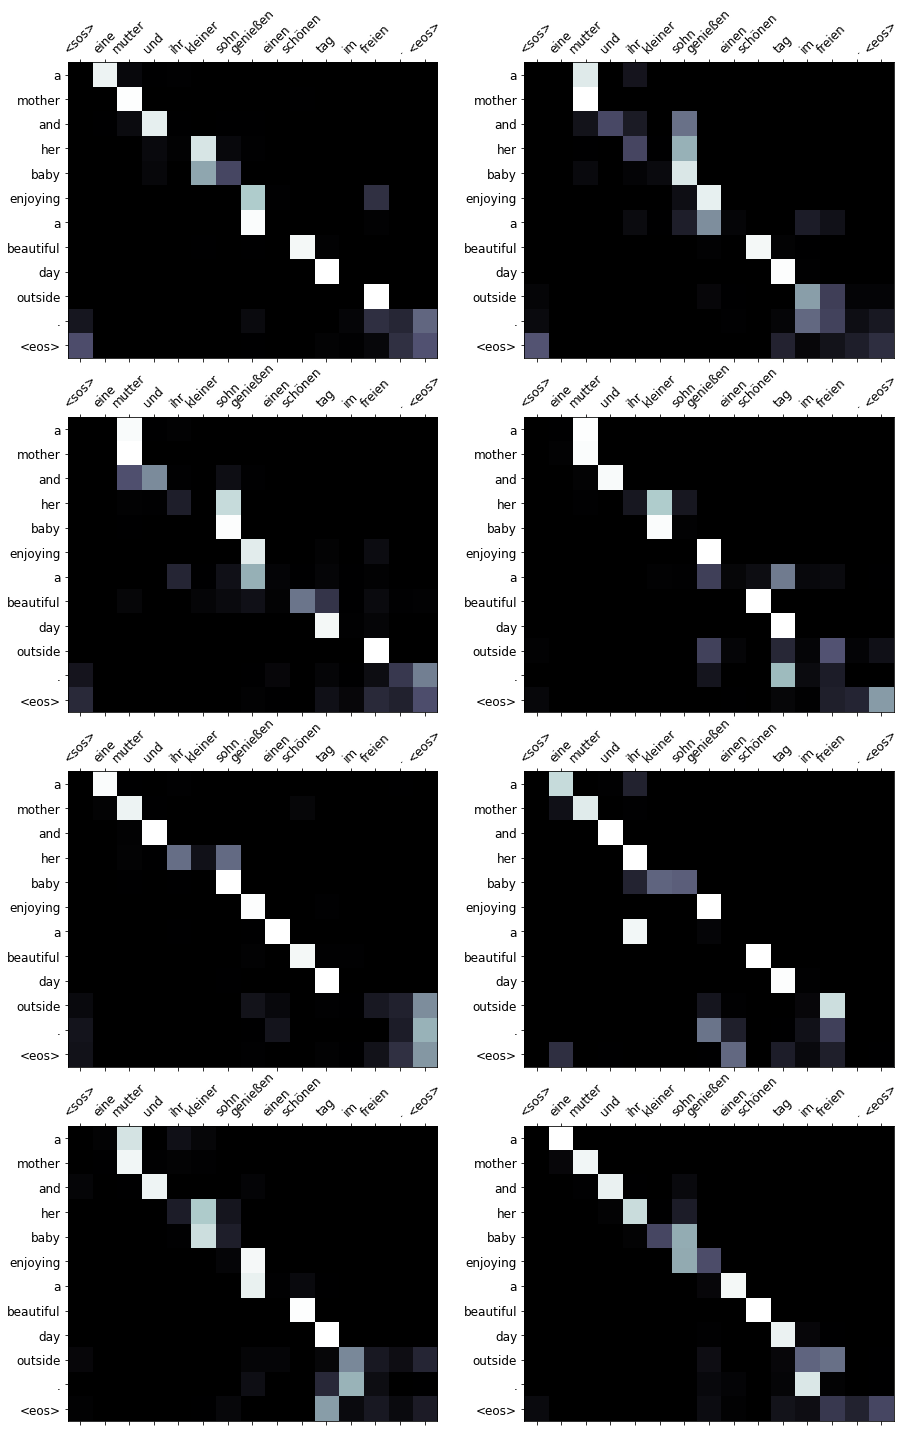

In [115]:
display_attention(src, translation, attention)

### **BLEU 계산**

In [116]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [117]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['a', 'group', 'of', 'asian', 'children', 'sit', 'in', 'blue', 'chairs', 'together', 'to', 'be', 'paying', 'blue', 'chairs', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[200/1000]
예측: ['all', 'in', 'the', 'group', 'of', 'people', 'stand', 'under', 'umbrellas', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[300/1000]
예측: ['a', 'goalie', 'in', 'a', 'yellow', 'jersey', 'is', 'shielding', 'the', 'goal', '.']
정답: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[400/1000]
예측: ['two', 'young', 'children', 'on', 'the', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[500/1000]
예측: ['two', 'brown', 'dogs', 'run', 'through', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
[600/1000]
예측: ['a', 'group', 'of', 'men', 'sit', 'and', 'talking', 'behind', 'a', '